In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
mu = 2 # gaussian mean from the original problem
sigma = np.sqrt(2) # original variance=2 from the problem

# gaussian function
f = lambda x: np.exp(-((x - mu) / sigma) ** 2 / 2) / (sigma * np.sqrt(2 * np.pi))

In [3]:
def MCMC(N, prop_var=1):
    """
    Sample a gaussian pdf using MCMC
    """
    
    # calculate the threshold probabilities in advance, since we can
    p = np.random.uniform(0, 1, N)

    # initialize the chains
    x0 = 0
    xs = np.zeros(N)
    xs[0] = x0

    # iterate over the number of samples
    for i in tqdm(range(1, N)):
        # threshold probability for this iteration
        p_threshold = p[i]

        # get the probability of the previous sample
        x_i = xs[i-1]
        p_i = f(x_i)

        # get a new point from the proposal distribution
        x_new = np.random.normal(x_i, prop_var)
        # calculate its probability
        p_new = f(x_new)

        # accept or reject the new point
        if (p_new / p_i) > p_threshold:
            # if we accept the new point, we keep it
            xs[i] = x_new
        else:
            # if we reject the new point, we use the previous sample as
            # our new sample
            xs[i] = x_i

    return xs.flatten()

## Problem 1)

In [4]:
N = int(1e6)
xs = np.exp(MCMC(N))

100%|██████████| 999999/999999 [00:02<00:00, 360470.95it/s]


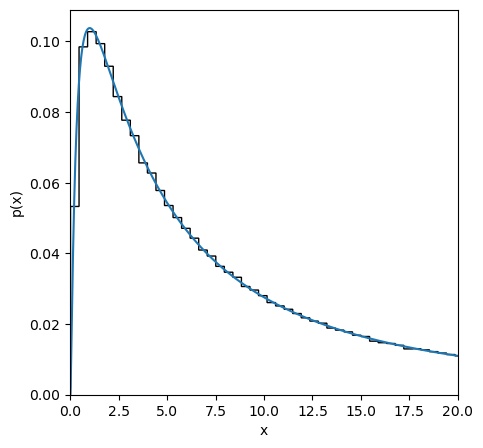

In [5]:
x = np.linspace(1e-10, 20, 1000) # the x-values from the Hogg plot for this problem

# in this case, we are sampling a log-normal, which has the following formula (from wikipedia)
y = f(np.log(x)) / x # pdf of a log-normal distribution

plt.figure(figsize=(5, 5))
plt.hist(xs, bins=10000, density=True, histtype='step', color='k')
plt.plot(x, y)
plt.xlim(0, 20)
plt.xlabel('x')
plt.ylabel('p(x)');

We see really nice agreement between the analytic log-normal pdf and our samples

## Problem 2)

In [6]:
# get gaussian samples
N = int(1e6)
xs = MCMC(N)

100%|██████████| 999999/999999 [00:02<00:00, 342858.28it/s]


Chain 1 mean: 2.006329239904819
Chain 1 variance: 1.9722468418412806
Chain 2 mean: 1.9926648682193486
Chain 2 variance: 1.99027940505375
Chain 3 mean: 2.0057059845681513
Chain 3 variance: 2.008279991731863
Chain 4 mean: 1.997644488799987
Chain 4 variance: 1.9941884773382486


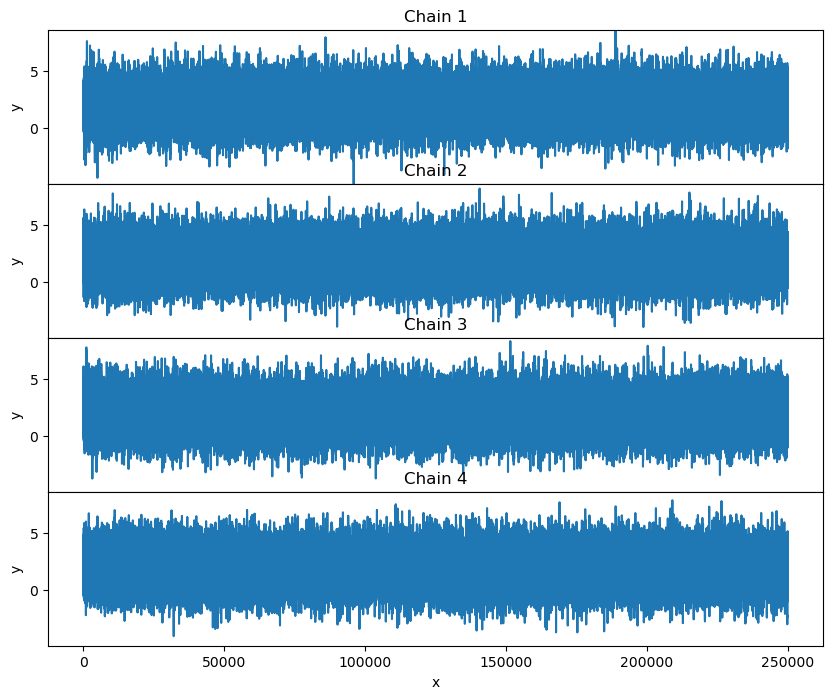

In [7]:
# make plots of the chain split into 4 parts

# set up the figure
fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
plt.subplots_adjust(hspace=0)

# start and end points for each sub-chain
start_points = [0, N//4, N//2, 3*N//4]
end_points = [N//4, N//2, 3*N//4, N]

for i in range(4):
    plt.subplot(4, 1, i+1)

    # plot each sub-chain
    plt.plot(xs[start_points[i]:end_points[i]])
    plt.title(f'Chain {i+1}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(xs.min(), xs.max())

for i in range(4):
    # calculate the mean and variance of each sub-chain
    print(f"Chain {i+1} mean: {np.mean(xs[start_points[i]:end_points[i]])}")
    print(f"Chain {i+1} variance: {np.var(xs[start_points[i]:end_points[i]])}")

As we can see, the chains all look identical. Looking at the means and variances, they are also practically identical. This tells you that the convergence is *extremely* fast. Maybe if our seed point was further away from the peak of the pdf, then it might take longer to converge, or perhaps if the pdf had a more complicated shape. Here, though, we get near-instant convergence, as we would hope for for such as simple pdf.

## Problem 3

In [8]:
def compute_autocorrelation(x):
    """
    Compute the autocorrelation of an array using fast Fourier transforms
    """
    # FFT needs the signal to be padded by zeros at the end, such that
    # the total length is 2n - 1 (n is the signal length).
    signal = np.zeros(len(x) * 2 - 1)

    # center the signal by subtracting the mean
    signal[:len(x)] = x - np.mean(x)

    # compute the FFTs
    fft1 = np.fft.fft(signal)
    fft2 = np.fft.fft(signal)

    # correlation is then the inverse FFT of the complex conjugate
    correlation = np.fft.ifft(fft1 * np.conjugate(fft2)).real

    # normalize the correlatoin by the variance and the length of the signal
    return correlation / np.var(x) / len(x)

def plot_autocorrelation(x):
    """
    Plot the results of the autocorrelation calculation
    """
    autocorrelation = compute_autocorrelation(x)
    plt.figure(figsize=(5, 5))
    plt.plot(autocorrelation)
    plt.xlim(0, 60)
    plt.ylim(-0.05, 1.05)
    plt.xlabel(r'$\Delta$')
    plt.ylabel(r'C$_x$($\Delta$)')

100%|██████████| 999999/999999 [00:02<00:00, 369308.57it/s]


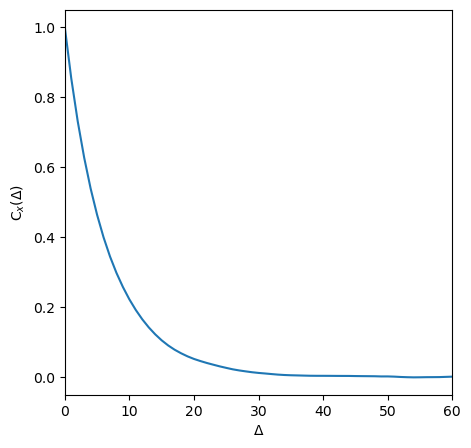

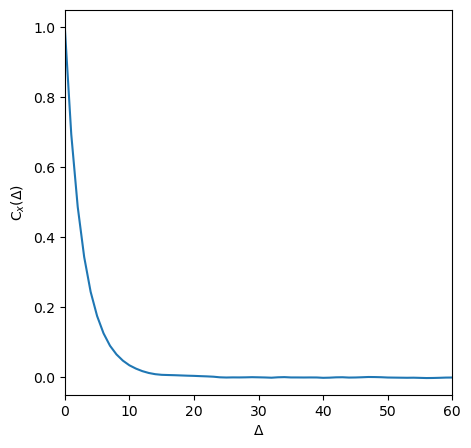

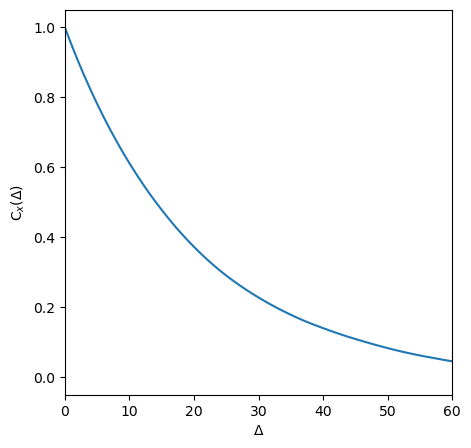

In [9]:
# autocorrelation of the original setup
xs = MCMC(1000000, prop_var=1)
plot_autocorrelation(xs)

# autocorrelation with doubled proposal variance
xs = MCMC(1000000, prop_var=2)
plot_autocorrelation(xs)

# autocorrelation with halved proposal variance
xs = MCMC(1000000, prop_var=1/2)
plot_autocorrelation(xs)

The first auto-correlation plot matches really nicely with the one in the paper, confirming the validity of this calculation. The autocorrelation drops to near-0 values much faster when the variance is high, and it's much slower when the variance is low. Thinking about this logically, we know that the autocorrelation measures roughly how similar one part of the signal is to other parts of the signal, a specific "distance" away (parameterized here by Delta). If the variance of our proposal distribution is very high, then we are likely to jump to new points very quickly, and move very far away, "forgetting" our original position more likely. Thus, for a fixed number of steps, we are less likely to resemble our original position, so the autocorrelation is lower. On the other hand, a low variance means we stick around where we are, so we're likely to resemble our current position even many steps down the line, increasing the autocorrelation.